## Lab 5: logistic regression. ROC. AUC. One-hot encoding

## 1
Consider the data from a health insurance company. Based on the characteristics of patients `Members.csv` (age, gender) and data on receiving medical care in the previous year `Claims_Y1.csv` (medical institution, doctor, type of problem, number of days of hospitalization, date, etc.), you need to predict the fact of hospitalization for at least 1 day in the next year `DaysInHospital_Y2.csv`.

In [1]:
import pandas as pd
import numpy as np
from sklearn import *
%matplotlib inline
import matplotlib.pyplot as plt

Read the data. Use `MemberID` as the value for parameter `index_col`. 

* data from the 'DaysInHospital_Y2.csv' table assign to the `days2` variable
* data from the 'Members.csv' table assign to the `m` variable
* data from the 'Claims_Y1.csv' table assign to the `claims` variable

In [2]:
# place for code
days2=pd.read_csv('DaysInHospital_Y2.csv',index_col='MemberID')
m=pd.read_csv('Members.csv',index_col='MemberID')
claims=pd.read_csv('Claims_Y1.csv' ,index_col='MemberID')

## 2
To anonymize data, the organizer provided approximate information about patients, for example, the age column shows age groups: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Convert string attributes to quantitative ones and replace the missing values:

In [3]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

## 3
Construct features using `claims` dta: 
* `f_Charlson` — the maximum index of Calson comorbidity for a patient (`CharlsonIndex` in a table `claims`)
* `f_LengthOfStay` — the total number of days of hospitalization last year (`LengthOfStay` in a table `claims`) 

*Functions that can be useful: `.groupby(['MemberID']), .max ().sum()`*

In [4]:
f_Charlson =claims['CharlsonIndex'].groupby(['MemberID']).max()
f_LengthOfStay = claims['LengthOfStay'].groupby(['MemberID']).sum()
dab =pd.get_dummies(claims.PrimaryConditionGroup, prefix='pcg')
f_pcg = dab.groupby(['MemberID']).max()
dab1 =pd.get_dummies(claims.Specialty, prefix='Sp')
f_sp = dab1.groupby(['MemberID']).max()
dab2 =pd.get_dummies(claims.ProcedureGroup, prefix='pg')
f_pg = dab2.groupby(['MemberID']).max()

## 4

Let's create a matrix of features with columns: `f_Charlson`, `f_LengthOfStay`, patient's age, `ClaimsTruncated` (whether there were too many cases of medical care):

*Functions that can be useful: `.join()`*

In [5]:
data = days2
data = data.join(f_Charlson)
data = data.join(f_LengthOfStay)
data = data.join(m.AgeAtFirstClaim)
data = data.join(f_pcg)
data = data.join(f_sp)
data = data.join(f_pg)
data.head(5)

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,pcg_AMI,pcg_APPCHOL,pcg_ARTHSPIN,pcg_CANCRA,pcg_CANCRB,...,pg_SDS,pg_SEOA,pg_SGS,pg_SIS,pg_SMCD,pg_SMS,pg_SNS,pg_SO,pg_SRS,pg_SUS
MemberID,,,,,,,,,,,,,,,,,,,,,
98324177,0,0,0,0,30,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33899367,1,1,0,0,80,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5481382,0,1,0,0,20,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
69908334,0,0,0,0,60,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
29951458,0,0,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5
Create a function that will divide the sample into two parts `dataTrain` and `dataTest`, train logistic regression on `dataTrain`, apply it to `dataTest`, build an error curve and calculate the area under it:

In [6]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Apply this function to `data`:

C:\Users\daban\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


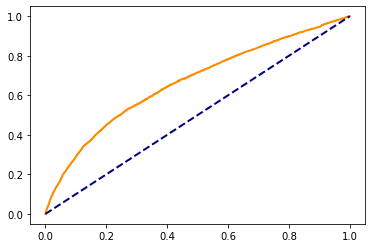

0.665932339274079


In [7]:
calcAUC(data)

## 7
Logistic regression accepts only quantitative features as input.

Add the patient's gender to our data using one hot encoding:

*Functions that can be useful: `pd.get_dummies(m.Sex, prefix='pol')`*

In [8]:
pd.get_dummies(m.Sex, prefix='pol')

,pol_F,pol_M,pol_N
MemberID,,,
14723353,0,1,0
75706636,0,1,0
17320609,0,1,0
69690888,0,1,0
33004608,0,1,0
...,...,...,...
99711514,1,0,0
31690877,1,0,0
9519985,1,0,0


## 8
Try applying one hot encoding to the existing features in `data2` or creating new features using the `claims` array.

In [9]:
data2=data.join(pd.get_dummies(m.Sex, prefix='pol'))
data2 = data2.join(pd.get_dummies(data2.AgeAtFirstClaim, prefix='Age'))
data2

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,pcg_AMI,pcg_APPCHOL,pcg_ARTHSPIN,pcg_CANCRA,pcg_CANCRB,...,Age_-1,Age_0,Age_10,Age_20,Age_30,Age_40,Age_50,Age_60,Age_70,Age_80
MemberID,,,,,,,,,,,,,,,,,,,,,
98324177,0,0,0,0,30,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33899367,1,1,0,0,80,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5481382,0,1,0,0,20,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
69908334,0,0,0,0,60,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
29951458,0,0,0,0,40,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702326,0,0,0,0,20,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
31530440,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
87102780,0,0,0,0,40,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Who built the feature matrix for which the logistic regression works with the best quality: +5 bonus points.

C:\Users\daban\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


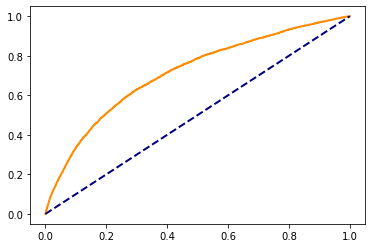

0.7137454465166326


In [10]:
calcAUC(data2)

In [11]:
def greedyalgorithmstep(current_dataset, allfeatures):
    result = []
    allcolumns = list(set(allfeatures.columns) - {'DaysInHospital'})
    
    for column in allcolumns:
        a = current_dataset.copy()
        a[column] = allfeatures[column]
        result.append(calcAUC(a))
    i = np.argmax(result)
    
    print(allcolumns[i], result[i])
    current_dataset[allcolumns[i]] = allfeatures[i]


In [ ]:
current_dataset = pd.DataFrame()
current_dataset['DaysInHospital'] = data2['DaysInHospital']

greedyalgorithmstep(current_dataset, data2)